# OCO-2 L2Met Relative Humidity Profiles

### Author: Jon Hobbs
### Date Authored: 05-20-25

This notebook illustrates the conversion of vertical profiles of specific humidity and temperature to corresponding profiles of relative humidity and temperature. These calculations are performed using data from OCO-2 Level 2 Meteorology (L2Met) support files, which are derived from the GEOS-IT products. 

The data access and calculations are executed on the cloud, and the first few sections of the notebook initiate the cloud access. In addition, some preliminary screening of OCO-2 soundings is performed using the Level 2 Lite (LtCO2) products. One month of data products is accessed and summarized.


## Import Libraries

In [1]:
import earthaccess
import xarray as xr
import s3fs
import numpy
import pandas
import datetime

## Search CMR Catalogs using earthaccess and Obtain S3 URLs

### Search for OCO-2 Lite Products

Request the desired OCO-2 products for specified date range and product version. Here the search is by the product's short name. The [OCO-2 "lite" CO2 product](https://doi.org/10.5067/8E4VLCK16O6Q) is used for this analysis. 

In [2]:
# Surface choice
sfctxt = 'Ocean'
sfcchc = 0
seastxt = '2018-08'

# LtCO2 and LtMet from OCO-2
# OCO2_L2_Lite_FP
short_name = 'OCO2_L2_Lite_FP'
version = '11.1r'
start_time = '2018-08-01'
end_time = '2018-08-31'

results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    cloud_hosted=True,
    temporal=(start_time,end_time)
)

s3_urls_v11 = [granule.data_links(access="direct")[0] for granule in results]
nlite = len(s3_urls_v11)
print(nlite)


30


### Get S3 Token

This step requires a valid .netrc file. Confirm your Earthdata Login credentials are stored in a .netrc file below.

In [3]:
auth = earthaccess.login(strategy="netrc")

daac = 'GES_DISC'
temp_s3_credentials = earthaccess.get_s3_credentials(daac)
def begin_s3_direct_access(url: str=daac):
    response = earthaccess.get_s3_credentials(daac)
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})
fs = begin_s3_direct_access()


### Loop Lite Files

Loop through the collection of lite files and assemble data frames with one row per sounding. This step also includes additional filtering on the quality flag and for the desired surface type.

In [4]:
# Loop through files
nsdglt = 0
for i in range(nlite):
    ltnc = xr.open_dataset(fs.open(s3_urls_v11[i]),
                           decode_cf=True,engine='h5netcdf')
    ltsdg = ltnc.sounding_id.values[:]
    ltlat = ltnc.latitude.values[:]
    ltlon = ltnc.longitude.values[:]
    ltxco2 = ltnc.xco2.values[:]
    ltflg = ltnc.xco2_quality_flag.values[:]
    ltnc.close()

    ltncrtr = xr.open_dataset(fs.open(s3_urls_v11[i]),
                              decode_cf=True,group="Retrieval",engine='h5netcdf')
    sfctp = ltncrtr.surface_type.values[:]
    ltncrtr.close()
    # Surface type: 0=water, 1=land

    # Orbit info
    ltncsdg = xr.open_dataset(fs.open(s3_urls_v11[i]),
                              decode_cf=True,group="Sounding",engine='h5netcdf')
    orbit = ltncsdg.orbit.values[:]
    ltncsdg.close()

    ltsdg = ltsdg.astype(numpy.int64)
    sfctpi = sfctp.astype(numpy.int16)
    orbit = orbit.astype(numpy.int32)
    ltflgi = ltflg.astype(numpy.int16)

    ltfrm = pandas.DataFrame({'SoundingID': ltsdg, 'Orbit': orbit, 'SfcType':sfctpi,
                              'Latitude': ltlat, 'Longitude': ltlon, 'XCO2': ltxco2, 'V11QFlag': ltflgi})
    # QF (good only) and sfc subset
    ltfrm = ltfrm[ (ltfrm['V11QFlag'] == 0) & (ltfrm['SfcType'] == sfcchc)]
    #print(ltfrm.dtypes)
    
    if nsdglt == 0:
        lt_all = ltfrm
    else:
        lt_all = pandas.concat([lt_all,ltfrm], ignore_index=True) 
    nsdglt = nsdglt + ltsdg.shape[0]

print(nsdglt)


4846138


### Group and Aggregate

For later matching, the full data frame is grouped by orbit.

In [5]:
def qsummary(df,vrlst):
    # Summarize with quantiles
    nmtch = df.shape[0] 
    dfout = pandas.DataFrame({'NSmp' : nmtch}, index=[0])
    #dfout[grpvr] = df[grpvr].values[0]
    for j in range(len(vrlst)):
        tmpdt = df[vrlst[j]]
        dtvld = tmpdt[numpy.isfinite(tmpdt)]
        dtvld = dtvld[dtvld != 0.0]
        vrnm = '%s_Med' % (vrlst[j])
        dfout[vrnm] = numpy.median(dtvld)

    return dfout

grpfrm = lt_all.groupby(['Orbit'])
sfcqs = grpfrm.apply(qsummary,include_groups=False,vrlst=['XCO2','Latitude','Longitude'])
sfcqs.reset_index(drop=False,inplace=True)
print(sfcqs.shape)


(278, 6)


### Search for L2Met Files

Loop through the collection of lite files and assemble data frames with one row per sounding. This step also includes additional filtering on the quality flag and for the desired surface type.

In [6]:
# OCO2_L2_Met, use same start time/end time
short_name = 'OCO2_L2_Met'
version = '11r'

results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    cloud_hosted=True,
    temporal=(start_time,end_time)
)

s3_urls_l2met = [granule.data_links(access="direct")[0] for granule in results]
print(len(s3_urls_l2met))


498


Create a data frame with the L2Met file information and merge with orbits obtained from lite files

In [7]:
# Create a data frame with L2Met info
l2sfrm = pandas.DataFrame({'S3File': s3_urls_l2met})
l2sfrm['ModeOrbStr'] = l2sfrm['S3File'].str.extract(r'(L2Met[A-Z]{2}_[0-9]{5}[a-z]{1})')
l2sfrm.dropna(subset=['ModeOrbStr'],inplace=True)
l2sfrm['OrbStr'] = l2sfrm['ModeOrbStr'].str.replace('L2Met[A-Z]{2}_', '', regex=True)
l2sfrm['Orbit'] = l2sfrm['OrbStr'].str.replace('[a-z]{1}','',regex=True)
l2sfrm['Orbit'] = l2sfrm['Orbit'].astype(numpy.int32)
print(l2sfrm[0:20])

# Merge Lite and L2
mrgorb = pandas.merge(sfcqs,l2sfrm, on='Orbit', how='inner')
print(mrgorb.shape)


                                               S3File      ModeOrbStr  OrbStr  \
0   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetGL_21709a  21709a   
1   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetGL_21710a  21710a   
2   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetGL_21711a  21711a   
3   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetND_21712a  21712a   
4   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetGL_21713a  21713a   
5   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetND_21714a  21714a   
6   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetGL_21715a  21715a   
7   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetND_21716a  21716a   
8   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetGL_21717a  21717a   
9   s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetGL_21718a  21718a   
10  s3://gesdisc-cumulus-prod-protected/OCO2_DATA/...  L2MetGL_21719a  21719a   
11  s3://gesdisc-cumulus-pro

### Loop Met Files

Loop through the collection of L2Met files and assemble data frames with one row per sounding. These are HDF5 files, so the `h5py` library is used.

For computing relative humidity, the following meteorology variables are extracted

* Specific humidity $q$, `/Meteorology/specific_humidity_profile_met`
* Temperature $T$, `/Meteorology/temperature_profile_met`
* Pressure levels $p$, `/Meteorology/vector_pressure_levels_met`

In addition, the summary will be performed for five selected vertical levels in the profile. Data for these specific levels are extracted.


In [8]:
# Loop L2Met collection
nl2met = mrgorb.shape[0]
nbtch = 0

import h5py

# Chosen levels
lvchc = [32,42,48,60,66]
nlvout = len(lvchc)

nsdgmet = 0
# Met profiles have dimension [nfrm,ncrs,nlev] 
for k in range(nl2met): 
    s3nmcr = mrgorb['S3File'].values[k]
    print(s3nmcr)
    l2h5 = h5py.File(fs.open(s3nmcr),'r')
    l2sdg = l2h5['/SoundingGeometry/sounding_id'][:,:]
    spchum = l2h5['/Meteorology/specific_humidity_profile_met'][:,:,lvchc]
    tmpprf = l2h5['/Meteorology/temperature_profile_met'][:,:,lvchc] 
    prsprf = l2h5['/Meteorology/vector_pressure_levels_met'][:,:,lvchc] 
    l2h5.close()

    nfrm = l2sdg.shape[0]
    ncrs = l2sdg.shape[1]

    frmsq = numpy.arange(nfrm)
    crssq = numpy.arange(ncrs)
    frmspt = numpy.repeat(frmsq,ncrs)
    crsspt = numpy.tile(crssq,nfrm)

    # Set up data frame
    l2gfrm = pandas.DataFrame({'SoundingID': l2sdg.flatten(), 'FrameIdx': frmspt, 'FPIdx': crsspt})
    for j in range(nlvout):
        nmhum = 'SHum_%02d' % (lvchc[j])
        nmtmp = 'Temp_%02d' % (lvchc[j])
        nmprs = 'Pres_%02d' % (lvchc[j])
        l2gfrm[nmhum] = spchum[:,:,j].flatten()
        l2gfrm[nmtmp] = tmpprf[:,:,j].flatten()
        l2gfrm[nmprs] = prsprf[:,:,j].flatten()

    # Subset lite and merge
    ltgrn = lt_all[ lt_all['Orbit'] == mrgorb['Orbit'].values[k]]
    metmrg = pandas.merge(l2gfrm, ltgrn, on='SoundingID', how='inner')
    metmrg['L2MetS3'] = s3nmcr

    if nsdgmet == 0:
        met_all = metmrg
    else:
        met_all = pandas.concat([met_all,metmrg], ignore_index=True) 
    nsdgmet = nsdgmet + metmrg.shape[0]

print(met_all.shape)

s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Met.11r/2018/213/oco2_L2MetGL_21709a_180801_B11006r_220727001740.h5
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Met.11r/2018/213/oco2_L2MetGL_21710a_180801_B11006r_220727005111.h5
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Met.11r/2018/213/oco2_L2MetGL_21711a_180801_B11006r_220727005057.h5
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Met.11r/2018/213/oco2_L2MetGL_21713a_180801_B11006r_220727001428.h5
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Met.11r/2018/213/oco2_L2MetGL_21715a_180801_B11006r_220727010531.h5
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Met.11r/2018/213/oco2_L2MetGL_21717a_180801_B11006r_220727004745.h5
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Met.11r/2018/213/oco2_L2MetGL_21718a_180801_B11006r_220726220011.h5
s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Met.11r/2018/213/oco2_L2MetGL_21719a_180801_B11006r_220726233114.h5
s3://gesdisc-cumulus-pro

In [9]:
met_all.dtypes

SoundingID      int64
FrameIdx        int64
FPIdx           int64
SHum_32       float32
Temp_32       float32
Pres_32       float32
SHum_42       float32
Temp_42       float32
Pres_42       float32
SHum_48       float32
Temp_48       float32
Pres_48       float32
SHum_60       float32
Temp_60       float32
Pres_60       float32
SHum_66       float32
Temp_66       float32
Pres_66       float32
Orbit           int32
SfcType         int16
Latitude      float32
Longitude     float32
XCO2          float32
V11QFlag        int16
L2MetS3        object
dtype: object

## Compute Relative Humidity

Relative humidity $RH$ can be computed as the ratio of the specific humidty $q$ to the saturation specific humidity $q_s$,
$$ RH = \frac{q}{q_s} $$

Saturation specific humidity is computed from the saturation vapor pressure $e_s$ and the air pressure $p$,
$$ q_s = 0.622 \frac{e_s}{p} $$

Saturation vapor pressure (in units of Pascals) is computed with the `calculate_es` routine. The saturation vapor pressure is a function of temperature only.


In [10]:
def calculate_es(temp):
    return 611*numpy.exp(17.67*(temp-273.15)/(temp-29.65))

# Compute RH by levels
for j in range(nlvout):
    nmhum = 'SHum_%02d' % (lvchc[j])
    nmtmp = 'Temp_%02d' % (lvchc[j])
    nmprs = 'Pres_%02d' % (lvchc[j])

    nmrh = 'RH_%02d' % (lvchc[j])

    qs = 0.622 * calculate_es(met_all[nmtmp]) / met_all[nmprs]
    met_all[nmrh] = met_all[nmhum] / qs

### Group and Summarize

Finally, the soundings are grouped into latitude bins and summary plots are constructed for each of the selected vertical levels.

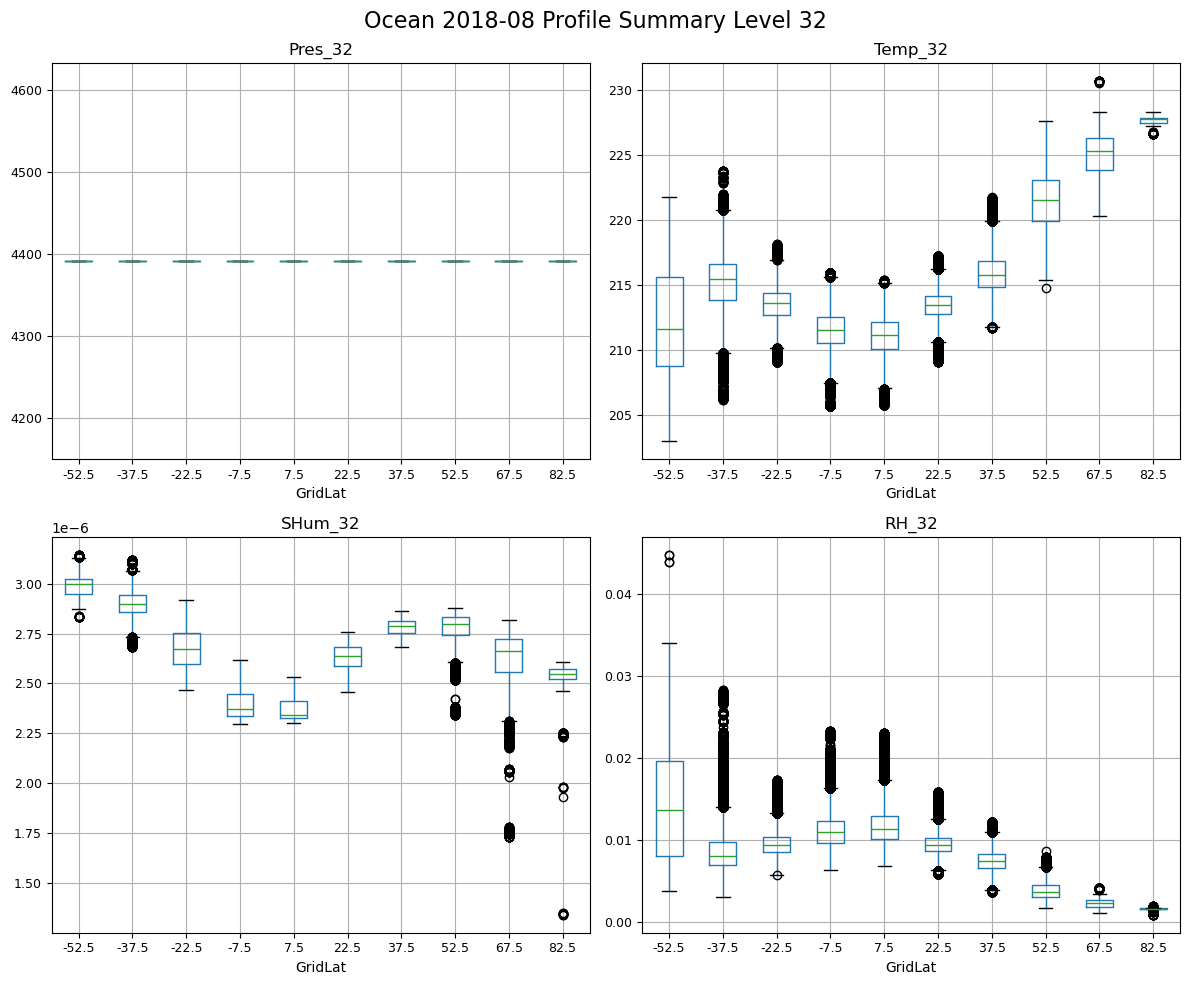

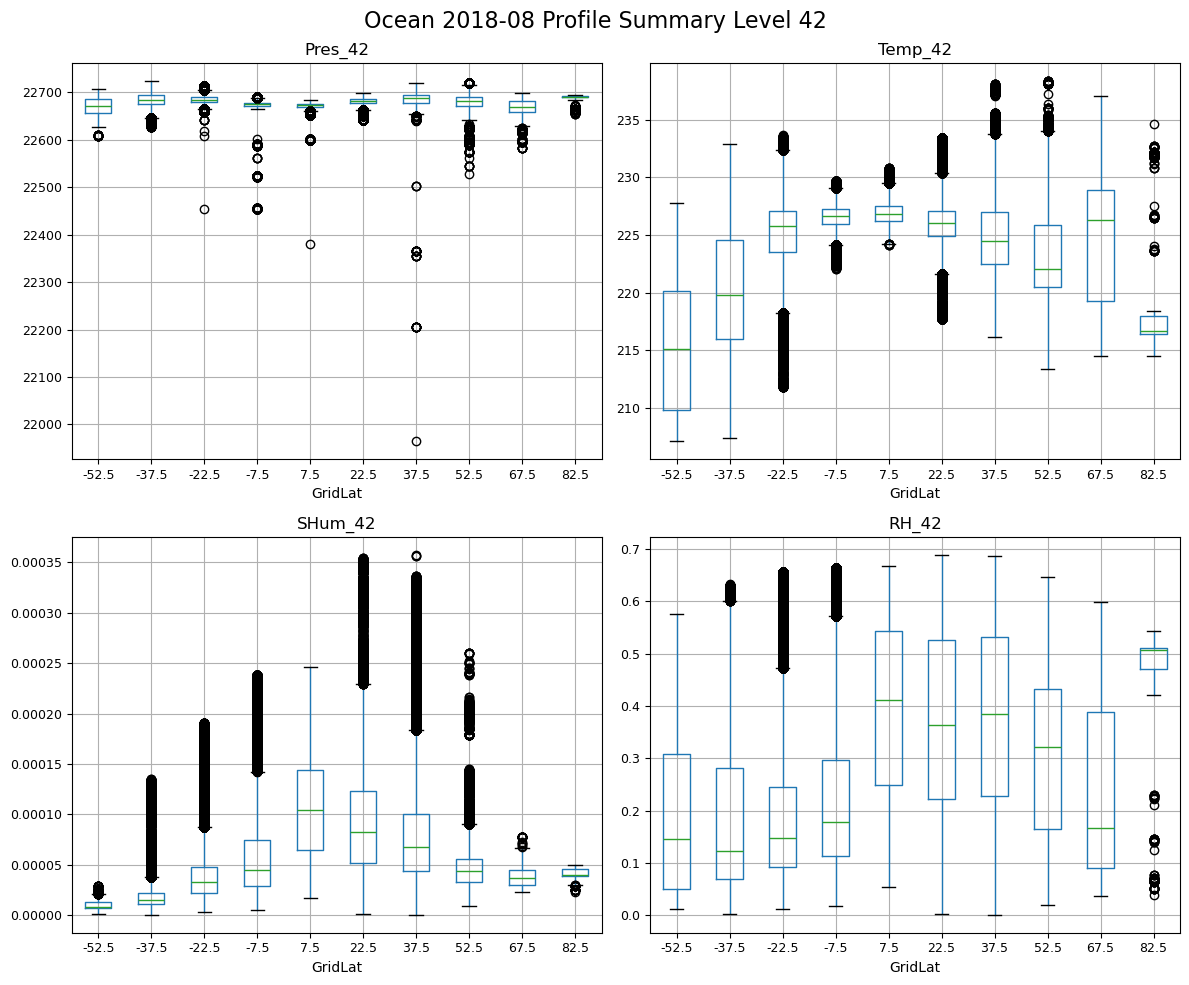

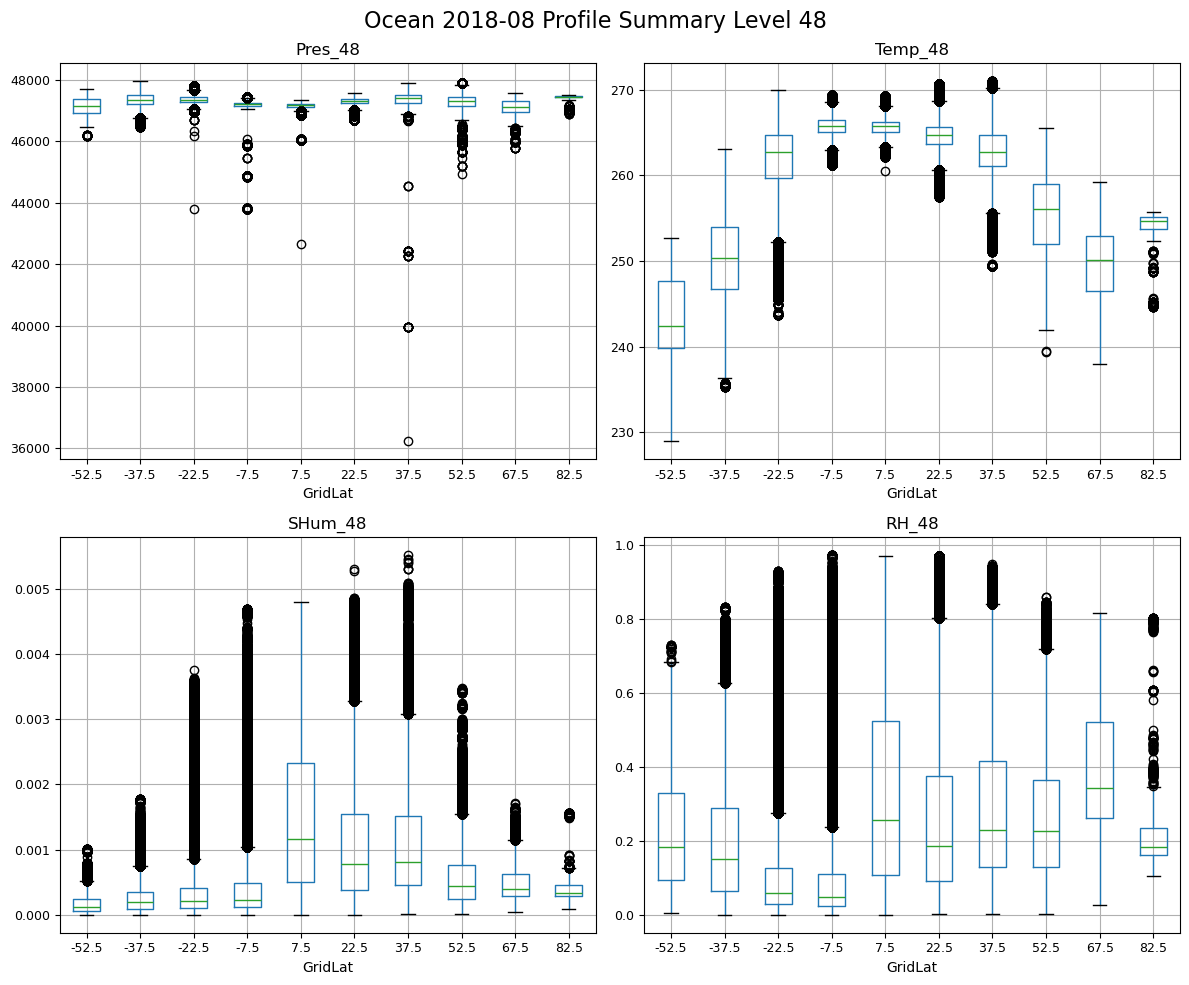

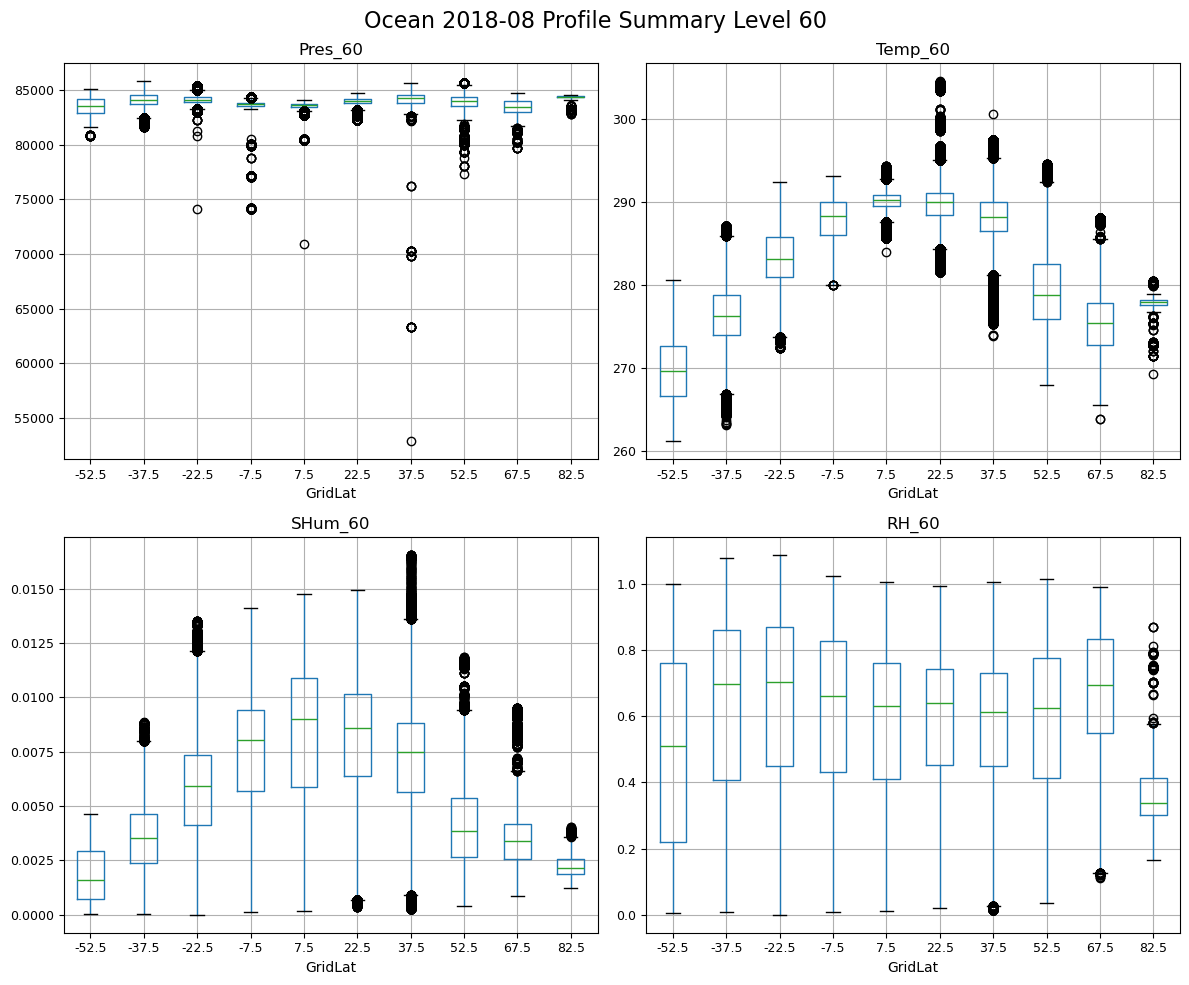

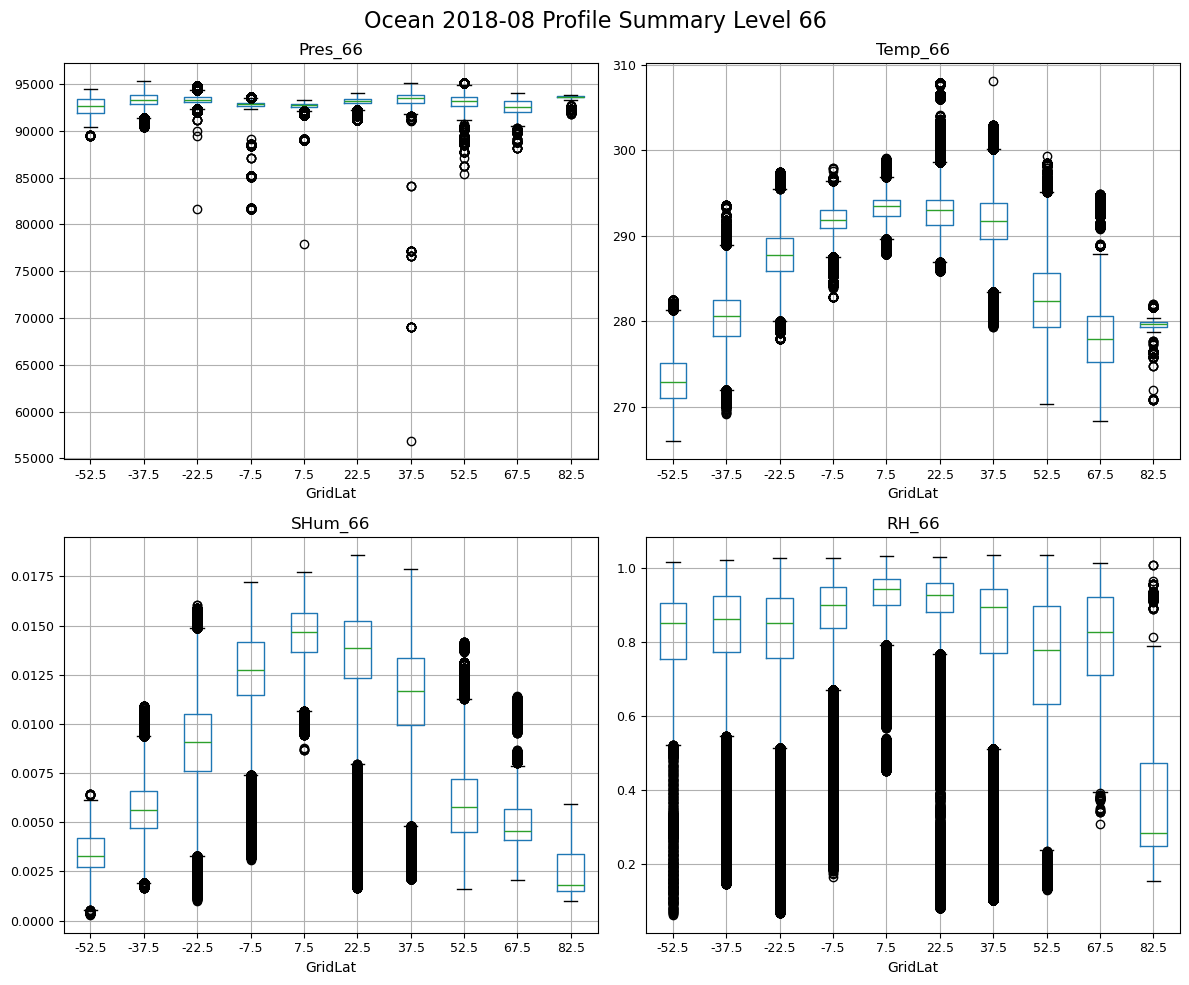

In [11]:
# Summarize and plot
# Latitude binning
ltfrq = 15.0
met_all['GridLat'] = numpy.floor(met_all['Latitude']/ltfrq) * ltfrq + ltfrq / 2.0

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

nmcl = ['Pres','Temp','SHum','RH']
# Plot by level

for j in range(nlvout):
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,10))

    for i in range(len(nmcl)):
        nmlv = '%s_%02d' % (nmcl[i], lvchc[j])
        axcr = axes.flatten()[i]
        met_all.boxplot(column=[nmlv], by="GridLat", ax=axes.flatten()[i])
        for lb in axcr.xaxis.get_ticklabels():
            lb.set_fontsize(9)
        for lb in axcr.yaxis.get_ticklabels():
            lb.set_fontsize(9)

    tstr = '%s %s Profile Summary Level %d' % (sfctxt, seastxt, lvchc[j])
    fig.suptitle(tstr,fontsize=16)
    
    plt.tight_layout() 
